# 1.1 Data exploration

In [34]:
# Import libraries
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import gstools as gs


In [2]:
# Specify filepaths and filenames.
filepath = 'Data/'
filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Make column with year from current year max date
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

C:\Users\kasj\AppData\Local\Temp\ipykernel_5832\1729600844.py:6: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


In [3]:
# Clean point where winter mass balance = 9.99
data[data['balance_winter']==9.99]
data = data[data['balance_winter'] != 9.99].reset_index(drop=True)

In [4]:
print('Total number of data points: ' + str(data.shape[0]))

Total number of data points: 4170


## Get stats for dataset

In [5]:
# Stats for quality of approximate locations and altitudes:
mean_loc_diff_east = data.loc[data['approx_loc'] != 'Y', 'diff_east'].mean()
min_loc_diff_east = data.loc[data['approx_loc'] != 'Y', 'diff_east'].min()
max_loc_diff_east = data.loc[data['approx_loc'] != 'Y', 'diff_east'].max()
sd_loc_diff_east = data.loc[data['approx_loc'] != 'Y', 'diff_east'].std()

mean_loc_diff_north = data.loc[data['approx_loc'] != 'Y', 'diff_north'].mean()
min_loc_diff_north = data.loc[data['approx_loc'] != 'Y', 'diff_north'].min()
max_loc_diff_north = data.loc[data['approx_loc'] != 'Y', 'diff_north'].max()
sd_loc_diff_north = data.loc[data['approx_loc'] != 'Y', 'diff_north'].std()

mean_altitude_diff = data.loc[data['approx_altitude'] != 'Y', 'diff_altitude'].mean()
min_altitude_diff = data.loc[data['approx_altitude'] != 'Y', 'diff_altitude'].min()
max_altitude_diff = data.loc[data['approx_altitude'] != 'Y', 'diff_altitude'].max()
sd_altitude_diff = data.loc[data['approx_altitude'] != 'Y', 'diff_altitude'].std()

# Number of instances of winter balance: 3680
no_winter = data['balance_winter'].notna().sum()

# Number of instances of summer balance: 3805
no_summer = data['balance_summer'].notna().sum()

# Number of instances of annual balance: 3839
no_annual = data['balance_netto'].notna().sum()

# Number of points with exact coordinates: 3717 of 4046
no_exact_locs = (data['approx_loc'].values == 'N').sum()

# Number of points with approximate coordinates: 329 of 4046
no_approx_locs = (data['approx_loc'].values == 'Y').sum()
    
# Number of points with exact altitude: 4009
no_exact_alt = (data['approx_altitude'].values == 'N').sum()

# Number of points with exact altitude: 37
no_approx_alt = (data['approx_altitude'].values == 'Y').sum()

# Number of points w/o exact coordinates or altitude: 32
no_approx_both = ((data['approx_altitude'].values == 'Y') & (data['approx_loc'].values == 'Y')).sum()
   
# Number of unique glacier IDs: 32
no_unique_id = data['BREID'].nunique()    

# List of unique glacier IDs:
list_unique_id = list(data['BREID'].unique())

# Unique glacier IDs with number of entries per ID.
# Index is glacier ID and column is number of entries per glacier ID.
len_rec_per_id = data['BREID'].value_counts().to_frame()    

In [6]:
# Summary
print('Total number of points: ' + str(data.shape[0]))
print('Number of unique ids: ' + str(no_unique_id))
print('Number of annual mass balance: ' + str(no_annual))
print('Number of winter mass balance: ' + str(no_winter))
print('Number of summer mass balance: ' + str(no_summer))
print('Lowest altitude: ' + str(int(data['altitude'].min())))
print('Highest altitude: ' + str(int(data['altitude'].max())))

Total number of points: 4170
Number of unique ids: 32
Number of annual mass balance: 3910
Number of winter mass balance: 3751
Number of summer mass balance: 3929
Lowest altitude: 190
Highest altitude: 2212


## Figure 2: Dataset stats

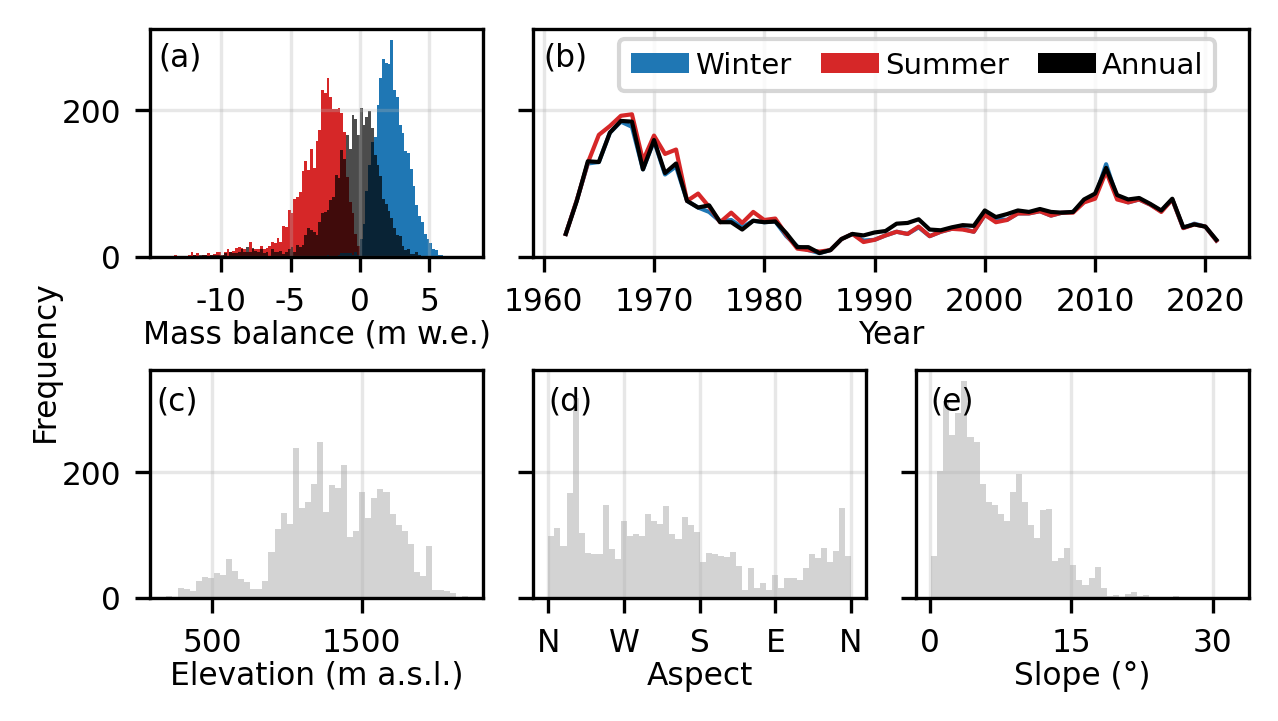

In [7]:
# Get annual, winter and summer data
data_netto = data[~data['balance_netto'].isnull()]
data_winter = data[~data['balance_winter'].isnull()]
data_summer = data[~data['balance_summer'].isnull()]

cm = 1/2.54
textsize_labels = 7.5
textsize_ticks = 7.5

fig = plt.figure(figsize=(12*cm,10*cm), dpi=300)

gs = fig.add_gridspec(3,3)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,-2:], sharey=ax1)
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1], sharey=ax3)
ax5 = fig.add_subplot(gs[1,2], sharey=ax3)

data['aspect_deg'] = data['aspect']*(180/3.14)
data['slope_deg'] = data['slope']*(180/3.14)

my_bins = np.arange(-14,8,0.2)

# Plot distributions
ax1.hist(data['balance_summer'], bins=my_bins,color='C3')
ax1.hist(data['balance_winter'], bins=my_bins,color='C0')
ax1.hist(data['balance_netto'], bins=my_bins,color='k', alpha=0.7)

# Plot number of measurements per year
data_winter.groupby(['year']).size().plot(color='C0', ax=ax2, linewidth=1)
data_summer.groupby(['year']).size().plot(color='C3', ax=ax2, linewidth=1)
data_netto.groupby(['year']).size().plot(color='k', ax=ax2, linewidth=1)

# Plot topographical stats
data['altitude'].plot.hist(bins=50, ax=ax3, color='lightgray')
data['aspect_deg'].plot.hist(bins=50, ax=ax4, color='lightgray')
data['slope_deg'].plot.hist(bins=50, ax=ax5, color='lightgray')

ax1.set_xticks([-10,-5,0,5], labels=[-10,-5,0,5], fontsize=textsize_ticks)
ax2.tick_params(axis='both', which='major', labelsize=textsize_ticks)
ax3.set_xticks([500,1500], labels=[500,1500], fontsize=textsize_ticks)
ax4.tick_params(axis='both', which='major', labelsize=textsize_ticks)
ax4.set_xticks([0,90,180,270,360], labels=['N','W','S','E','N'], fontsize=textsize_ticks)
ax5.set_xticks([0,15,30], labels=[0,15,30], fontsize=textsize_ticks)

ax1.tick_params(axis='both', which='major', labelsize=textsize_ticks)
ax3.tick_params(axis='both', which='major', labelsize=textsize_ticks)

color = ['C0','C3','k']
legend_patches = [Patch(facecolor=col, edgecolor=None, label=label) for col, label in zip(color, ['Winter','Summer','Annual'])]
ax2.legend(handles=legend_patches,loc = 'upper left', fontsize=7, labelspacing=0.2, bbox_to_anchor=(0.1,1.02), ncols=3, columnspacing=1, handletextpad=0.2)

ax1.set_ylabel('')
ax3.set_ylabel('')
fig.supylabel('Frequency', fontsize=textsize_labels, y=0.6, x=0.04)
ax1.set_xlabel('Mass balance (m w.e.)', fontsize=textsize_labels, labelpad=0.5)
ax2.set_xlabel('Year', fontsize=textsize_labels, labelpad=0.5)
ax3.set_xlabel('Elevation (m a.s.l.)', fontsize=textsize_labels, labelpad=0.5)
ax4.set_xlabel('Aspect', fontsize=textsize_labels, labelpad=0.5)
ax5.set_xlabel('Slope (°)', fontsize=textsize_labels, labelpad=0.5)
ax1.grid(alpha=0.3, zorder=0)
ax2.grid(alpha=0.3, zorder=0)
ax3.grid(alpha=0.3, zorder=0)
ax4.grid(alpha=0.3, zorder=0)
ax5.grid(alpha=0.3, zorder=0)

ax1.annotate('(a)', xy=(-14.5,260), fontsize=textsize_ticks, zorder=3)
ax2.annotate('(b)', xy=(1960,260), fontsize=textsize_ticks, zorder=3)
ax3.annotate('(c)', xy=(130,300), fontsize=textsize_ticks, zorder=3)
ax4.annotate('(d)', xy=(-0.2,300), fontsize=textsize_ticks, zorder=3)
ax5.annotate('(e)', xy=(-0.01,300), fontsize=textsize_ticks, zorder=3)

plt.subplots_adjust(hspace=0.5, wspace=0.15)

#pdf_path = 'C:/Users/kasj/OneDrive - Høgskulen på Vestlandet/Projects/2022_ML_for_MB_Norway/Figures_paper/'
#plt.savefig(pdf_path+'dataset_stats.pdf', format='pdf', bbox_inches='tight')



## Additional plots: Stats per location and glacier

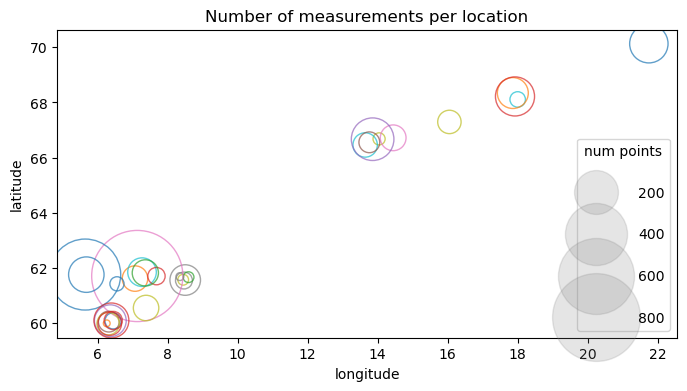

In [8]:
# Plot number of measurements per latitude and longitude

colors = np.random.rand(data['RGIID'].unique().size)
c = plt.cm.tab10(colors)

plt.figure(figsize=(8,4))
sc=plt.scatter(x=data.groupby(["RGIID"])['lon'].mean().values, 
               y=data.groupby(["RGIID"])['lat'].mean().values, 
               s=data.groupby(["RGIID"]).size().values*4,
               facecolors='None', edgecolors=c, lw=1, alpha=0.7)

handles, labels = sc.legend_elements(prop="sizes", alpha=0.2, num=5, color='grey')
labels = ["200", "400", "600", "800"]     
legend = plt.legend(handles, labels, loc="lower right", title="num points",labelspacing=2, handletextpad=2)
plt.title('Number of measurements per location')
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.show()

<Figure size 640x480 with 0 Axes>

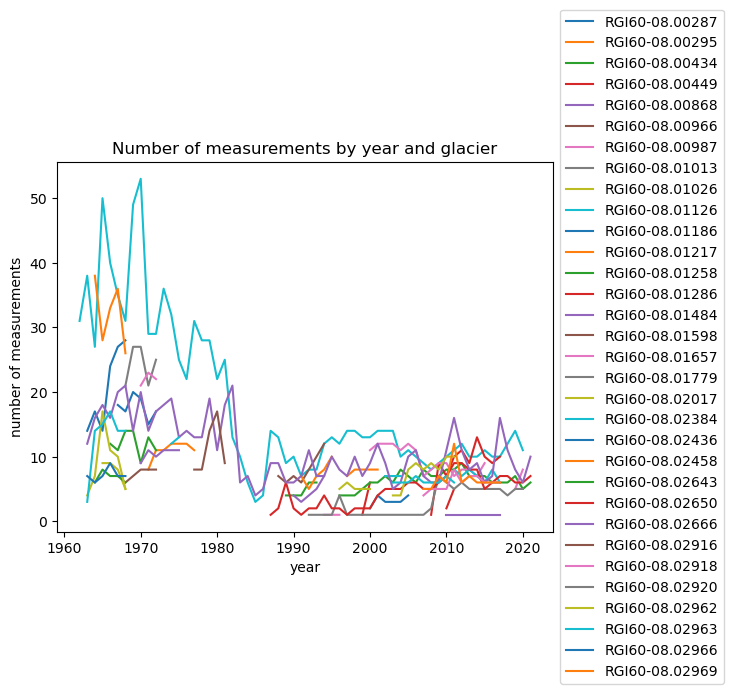

In [9]:
# Plot number of measurements per glacier

plt.figure()
data.groupby(['year', "RGIID"]).size().unstack().plot()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Number of measurements by year and glacier')
plt.ylabel('number of measurements')
plt.show()

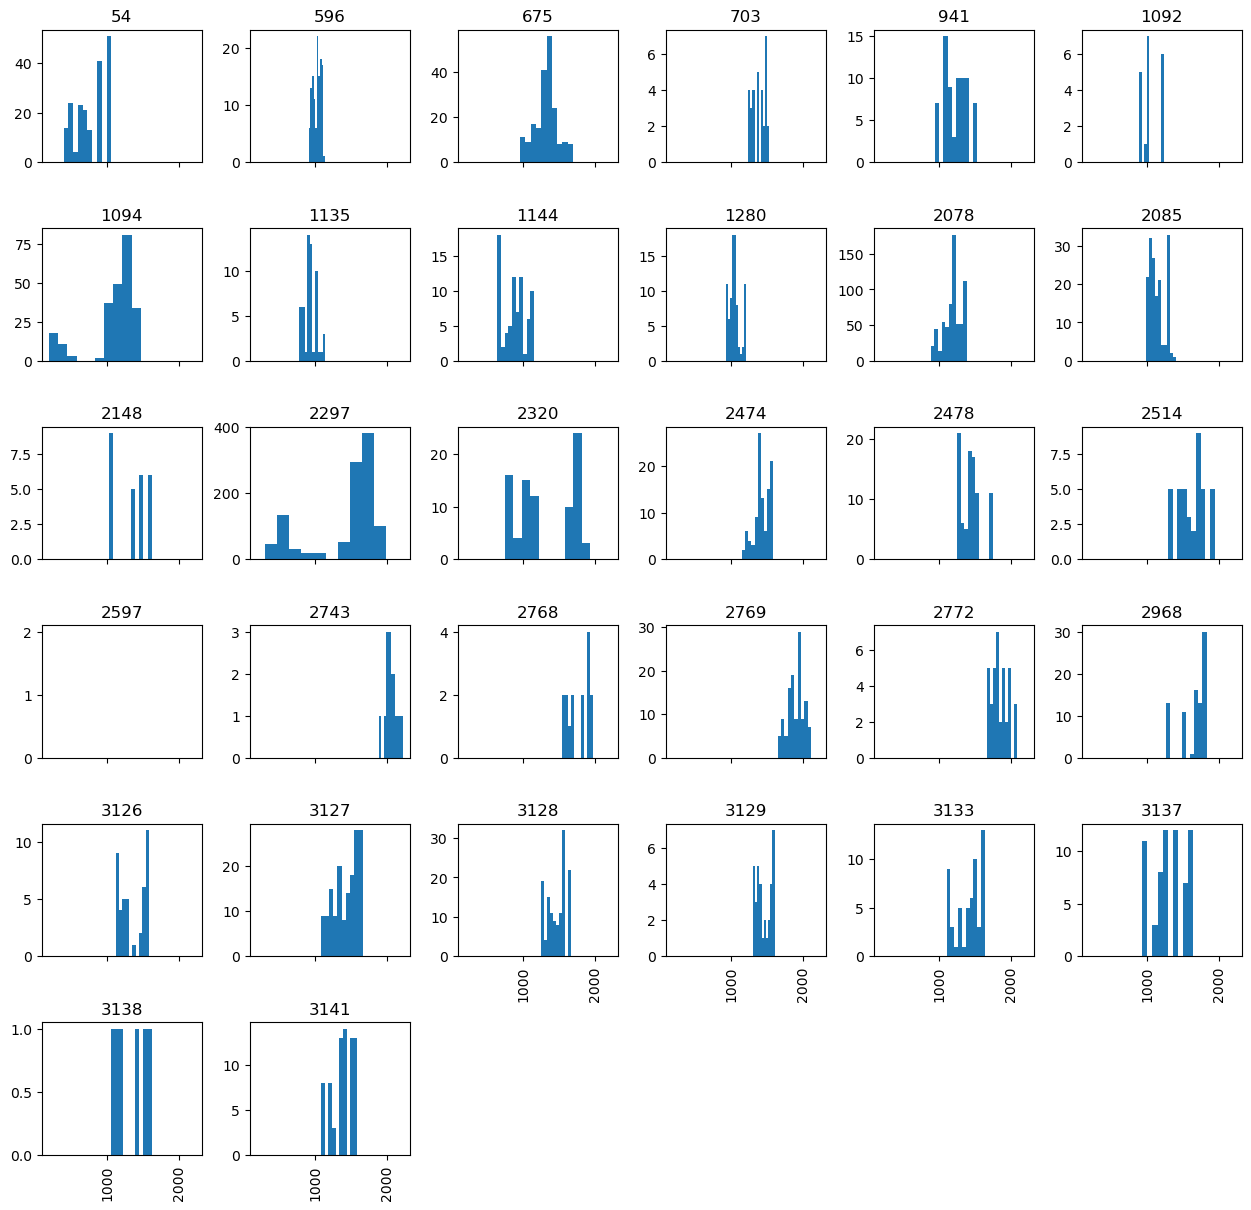

In [10]:
# Plot altitude distribution per glacier

data['altitude'].hist(by=data['BREID'], figsize=(15,15), sharex=True, grid=True)
plt.show()

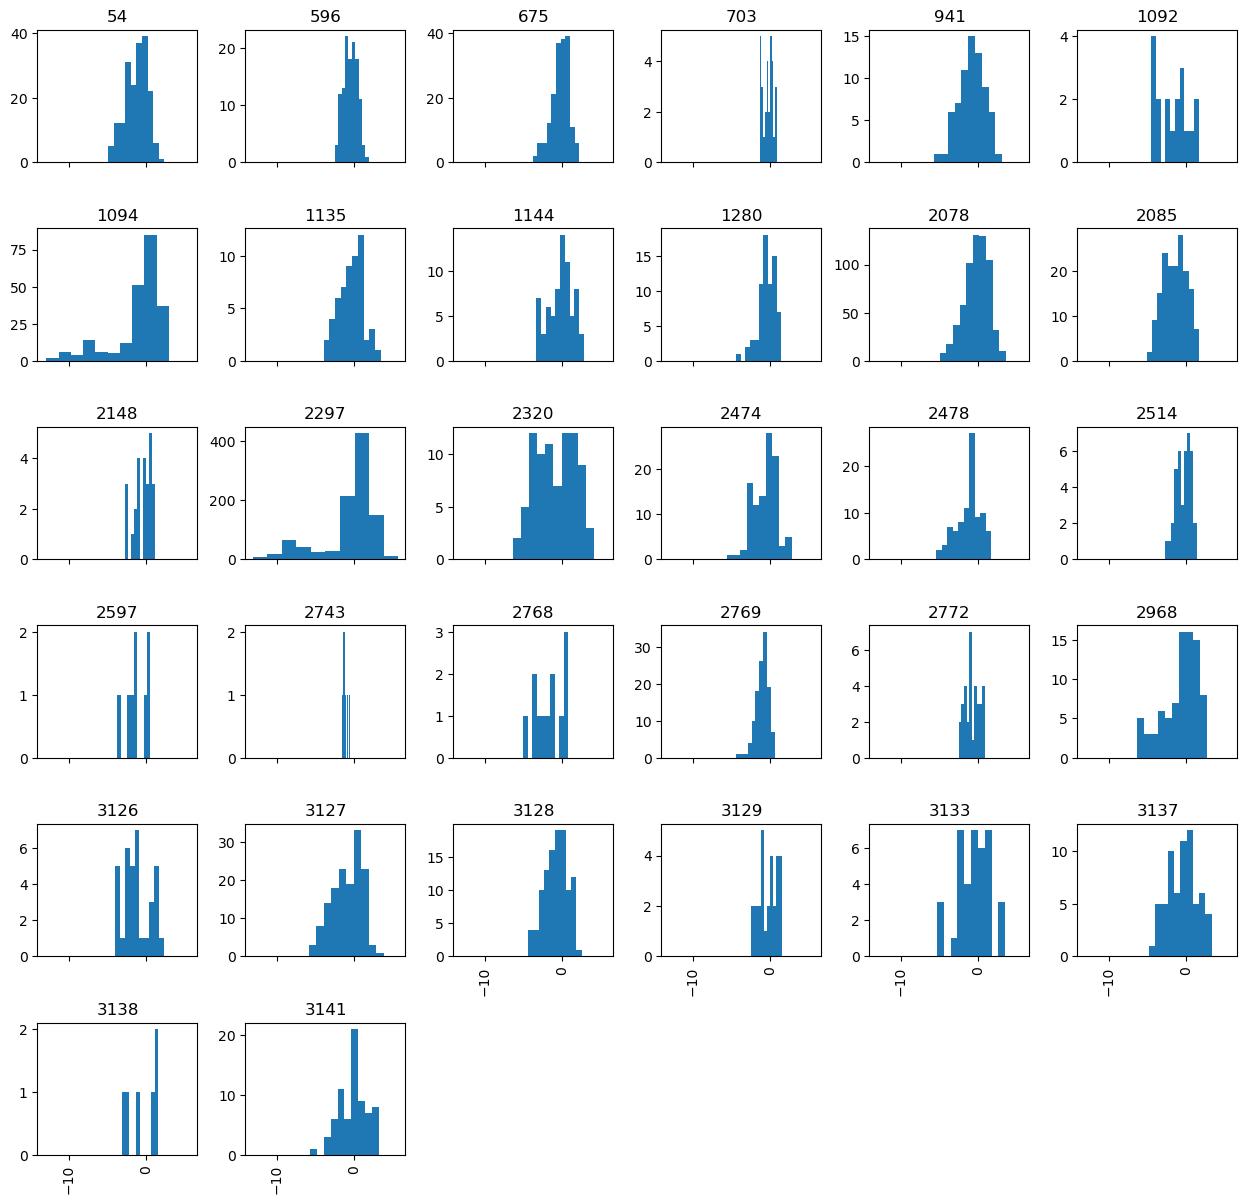

In [11]:
# Plot annual mass balance per glacier

data['balance_netto'].hist(by=data['BREID'], figsize=(15,15), sharex=True, grid=True)
plt.show()

In [12]:
print('Number of measurements of mass balance values lower than -5 m w.e.: ', data[(data['balance_netto']<-5.0)].BREID.count())
print('Glaciers with mass balance values lower than -5 m w.e.: ', data[(data['balance_netto']<-5.0)].BREID.unique())
print('Number of measurements of mass balance values lower than -10 m w.e.: ', data[(data['balance_netto']<-10.0)].BREID.count())
print('Glaciers with mass balance values lower than -10 m w.e.: ', data[(data['balance_netto']<-10.0)].BREID.unique())

Number of measurements of mass balance values lower than -5 m w.e.:  196
Glaciers with mass balance values lower than -5 m w.e.:  [ 941 1094 2085 2297 2320 2474 2478 2768 2968 3127 3133 3141]
Number of measurements of mass balance values lower than -10 m w.e.:  24
Glaciers with mass balance values lower than -10 m w.e.:  [1094 2297]


## Additional plots: Plot mass balance gradients per region

In [13]:
#Dictionary of region per glacier ID
mapping = {54 : 'FIN', 596 : 'NAR', 675 : 'NAR', 703 : 'NAR', 941 : 'BLA', 1092 : 'SVA',
           1094 : 'SVA', 1135 : 'SVA', 1144 : 'SVA', 1280 : 'SVA', 2078 : 'ALF',
           2085 : 'ALF', 2148 : 'JOB', 2297 : 'JOB', 2320 : 'JOB', 2474 : 'JOB',
           2478 : 'JOB', 2514 : 'JOB', 2597 : 'JOT', 2968 : 'HAR', 2768 : 'JOT',
           2769 : 'JOT', 2772 : 'JOT', 2743 : 'JOT', 3126 : 'FOL', 
           3127 : 'FOL', 3128 : 'FOL', 3129 : 'FOL', 3133 : 'FOL', 3137 : 'FOL', 
           3138 : 'FOL', 3141 : 'FOL'}

# Map region to glacier ID
data['region'] = data.BREID.map(mapping)


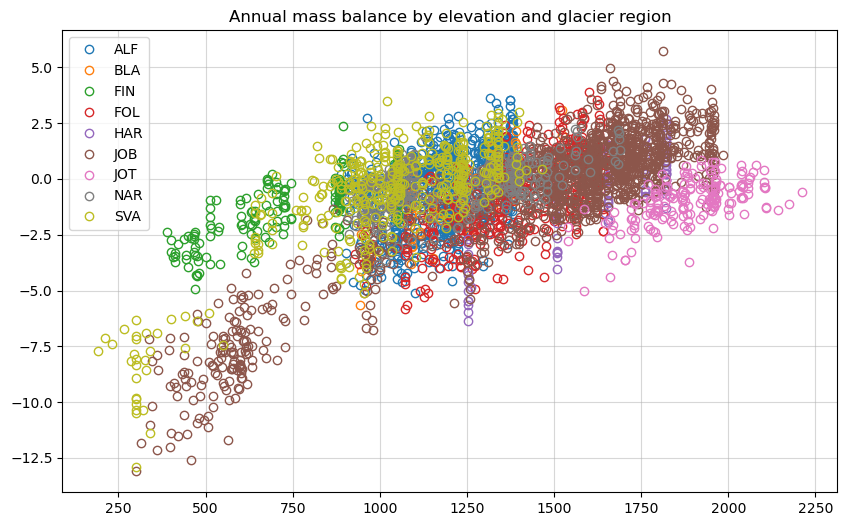

In [14]:
# Plot mass balance as a function of elevation per region

# Group glaciers by region
groups = data.groupby('region')

fig, ax = plt.subplots(figsize=(10,6))
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.altitude, group.balance_netto, marker='o', linestyle='', ms=6, label=name, mfc='None')
ax.legend()
ax.set_title('Annual mass balance by elevation and glacier region')
plt.grid(alpha=0.5)
plt.show()

In [15]:
#Dictionary of geographical location per region
mapping_reg = {'FIN' : 'N', 'BLA' : 'N', 'NAR' : 'N', 'SVA' : 'N', 
           'ALF' : 'W-mar', 'FOL' : 'W', 'HAR' : 'W', 'JOB' : 'W', 'JOT' : 'E'}

# Map region to geographical location
data['geo_region'] = data.region.map(mapping_reg)


E
196
N
1088
W
2070
W-mar
816


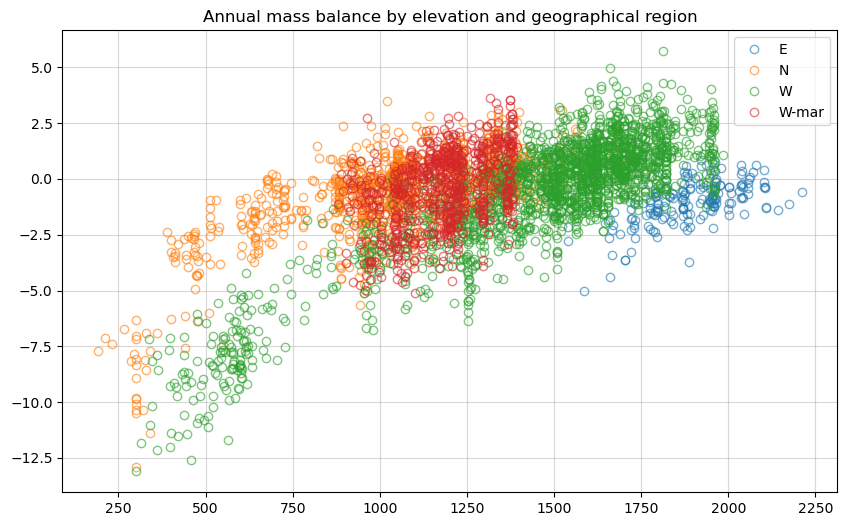

In [16]:
# Plot mass balance as a function of elevation for broader geographical region

# Group glaciers by broader geographical region
groups = data.groupby('geo_region')

fig, ax = plt.subplots(figsize=(10,6))
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.altitude, group.balance_netto, marker='o', linestyle='', ms=6, label=name, mfc='None', alpha=0.6)
    print(name)
    print(group.shape[0])
ax.legend()
ax.set_title('Annual mass balance by elevation and geographical region')
plt.grid(alpha=0.5)
plt.show()

In [17]:
print('Number of measurements of mass balance values lower than -5 m w.e.: ', data[(data['balance_netto']<-5.0)].BREID.count())
print('Glaciers with mass balance values lower than -5 m w.e.: ', data[(data['balance_netto']<-5.0)].BREID.unique())
print('Number of measurements of mass balance values lower than -10 m w.e.: ', data[(data['balance_netto']<-10.0)].BREID.count())
print('Glaciers with mass balance values lower than -10 m w.e.: ', data[(data['balance_netto']<-10.0)].BREID.unique())

Number of measurements of mass balance values lower than -5 m w.e.:  196
Glaciers with mass balance values lower than -5 m w.e.:  [ 941 1094 2085 2297 2320 2474 2478 2768 2968 3127 3133 3141]
Number of measurements of mass balance values lower than -10 m w.e.:  24
Glaciers with mass balance values lower than -10 m w.e.:  [1094 2297]


## Additional plots: Plot mass balance gradient per glacier 

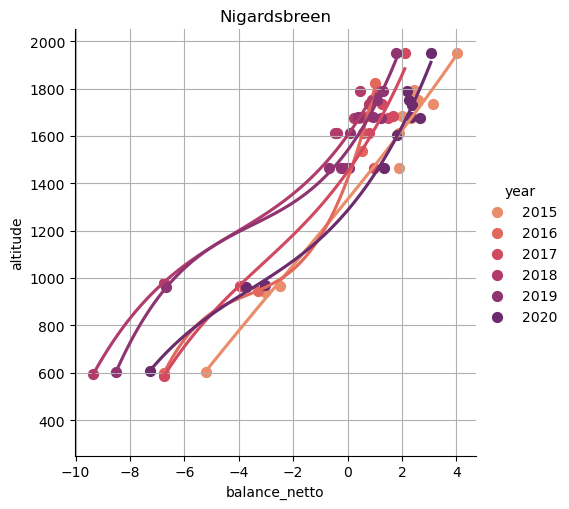

In [18]:
# Nigardsbreen mass balance gradient
# Nigardsbreen altitude range 1952 m a.s.l. down to 330 m a.s.l. (from NVE "Glaciological investigations in Norway 2018). 

data_nig = data[data['BREID']==2297]
#list_yrs = [1962, 1963, 1964, 1989, 1990, 1991, 1992, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
#            2005, 2006, 2007, 2008, 2010, 2011, 2012, 2013, 2015, 2016, 2017, 2018, 2019, 2020]
data_nig_2000 = data_nig[(data_nig['year']>2014) & (data_nig['year']<2022)] # 2014 to 2021

s=sns.lmplot(x='balance_netto', y='altitude', data=data_nig_2000, hue='year', ci=None, order=3, palette='flare', truncate=True,
            x_estimator=np.mean, fit_reg=True)
plt.grid()
s.set(ylim=(250, 2050))
plt.title('Nigardsbreen')
plt.show()


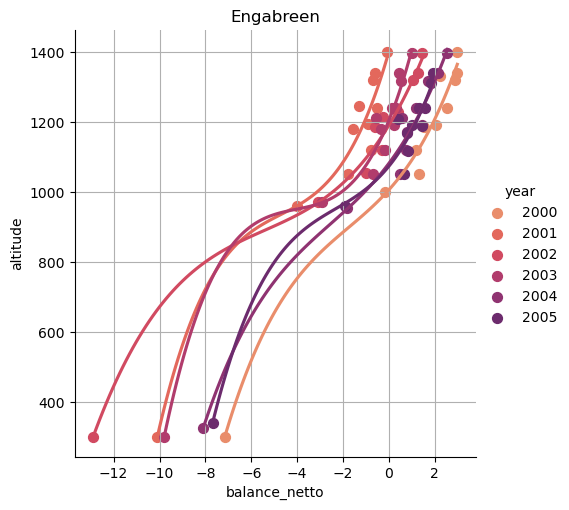

In [19]:
# Engabreen mass balance gradient
# Engabreen altitude range 111-1544 masl. (from NVE "Glaciological investigations in Norway 2018). 

data_eng= data[data['BREID']==1094]
data_eng_2000 = data_eng[(data_eng['year']>1999) & (data_eng['year']<2006)]

s=sns.lmplot(x='balance_netto', y='altitude', data=data_eng_2000, hue='year', ci=None, order=3, palette='flare', truncate=True,
            x_estimator=np.mean)
plt.grid()
plt.title('Engabreen')
plt.show()


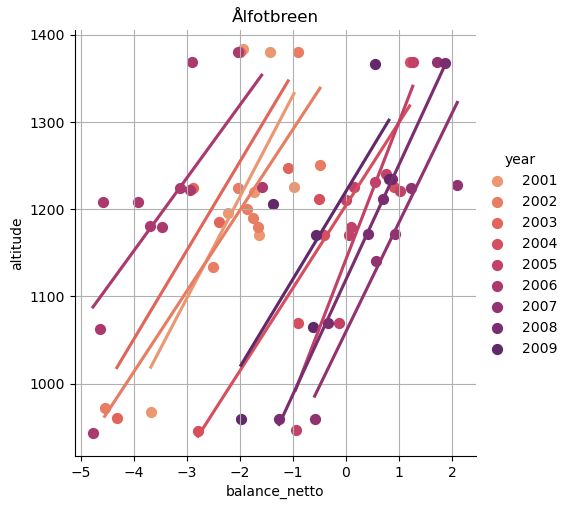

In [20]:
# Ålfotbreen mass balance gradient
# Ålfotbreen altitude range 890-1368 masl. (from NVE "Glaciological investigations in Norway 2018). 

data_alf= data[data['BREID']==2078]
data_alf_2000 = data_alf[(data_alf['year']>2000) & (data_alf['year']<2010)]

s=sns.lmplot(x='balance_netto', y='altitude', data=data_alf_2000, hue='year', ci=None, order=1, palette='flare', truncate=True,
            x_estimator=np.mean)
plt.grid()
plt.title('Ålfotbreen')
plt.show()


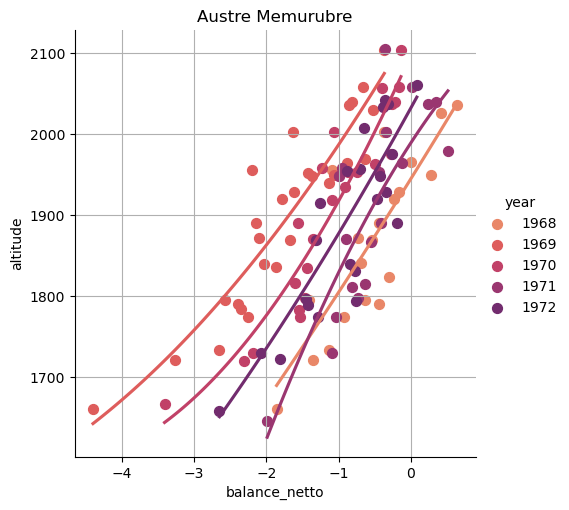

In [21]:
# Austre Memurubre mass balance gradient
# Austre Memurubre altitude range XXXX-XXXX masl.  

data_alf= data[data['BREID']==2769]
data_alf_2000 = data_alf[(data_alf['year']>1960) & (data_alf['year']<2010)]

s=sns.lmplot(x='balance_netto', y='altitude', data=data_alf_2000, hue='year', ci=None, order=2, palette='flare', truncate=True,
            x_estimator=np.mean)
plt.grid()
plt.title('Austre Memurubre')
plt.show()

## Auto-correlation analysis

Autocorrelation is just the correlation of the data with itself. Instead of measuring the correlation between two random variables, 
we are measuring the correlation between a random variable against itself.

In [22]:
data_nig = data[data['BREID']==2297]

In [23]:
data_nig['count'] = data_nig['location_id'].map(data_nig['location_id'].value_counts())
data_nig = data_nig.sort_values(['count','location_id'], ascending=[False, True]).drop('count', axis=1)

# List of 10 stakes locations with longest series
#10 stake locations with length (years): 58, 55, 49, 45, 42, 41, 38, 37, 36, 35
stake_list = data_nig.location_id.unique()[0:10]


C:\Users\kasj\AppData\Local\Temp\ipykernel_5832\991708362.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nig['count'] = data_nig['location_id'].map(data_nig['location_id'].value_counts())


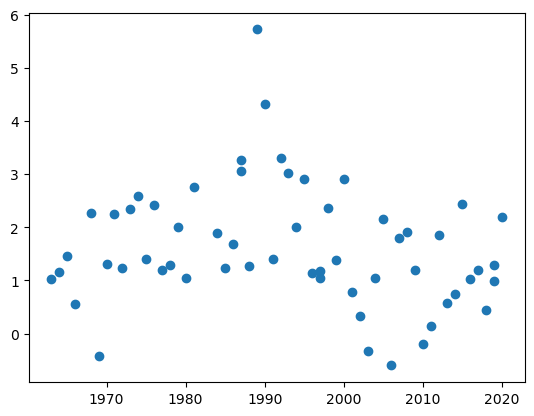

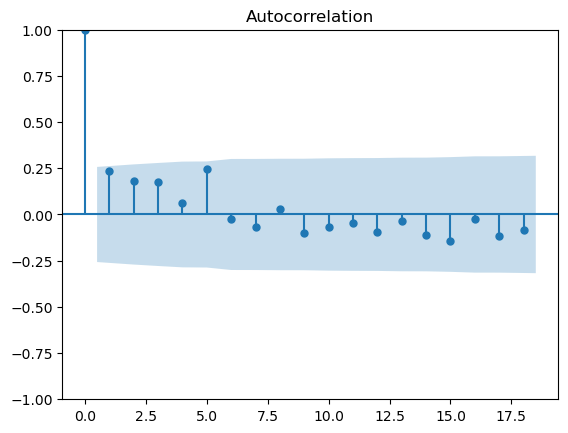

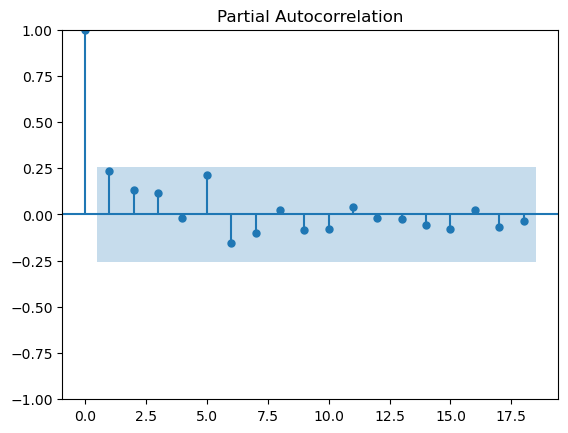

In [24]:
data_stake = data_nig[data_nig.location_id == stake_list[0]]

plt.plot(data_stake['year'], data_stake['balance_netto'], marker = 'o', linestyle='')
plt.show()

plot_acf(x=np.flip(data_stake['balance_netto'].values))
plt.show()

plot_pacf(x=np.flip(data_stake['balance_netto'].values))
plt.show()

In [25]:
# Some stake locations contain more than one stake measurements:
data_stake.loc[(data_stake['year']==1995), ['stake_no','altitude','utm_east','utm_north','balance_netto','dt_curr_year_min_date','dt_curr_year_max_date']]

,stake_no,altitude,utm_east,utm_north,balance_netto,dt_curr_year_min_date,dt_curr_year_max_date
2490,N56,1801.0,398068.0,6841212.0,2.91,30.09.1995 00:00,23.04.1995 00:00


# Variograms

The variogram relates the separating distance between two observation points to a measure of observation similarity at that given distance (https://scikit-gstat.readthedocs.io/en/latest/userguide/variogram.html).

The nugget is the y-intercept of the variogram. In practical terms, the nugget represents the small-scale variability of the data. A portion of that short range variability can be the result of measurement error. The range is the distance after which the variogram levels off. The physical meaning of the range is that pairs of points that are this distance or greater apart are not spatially correlated. The sill is the total variance contribution, or the maximum variability between pairs of points. (https://vsp.pnnl.gov/help/Vsample/Kriging_Variogram_Model.htm#:~:text=The%20nugget%20is%20the%20y,which%20the%20variogram%20levels%20off.)

If variance is increasing with distance, points that are distant to each other are less related.

See: https://www.aspexit.com/variogram-and-spatial-autocorrelation/

- For instance, for the exponential model, the range is defined as the distance at which the semi-variance reaches 95% of the sill.

 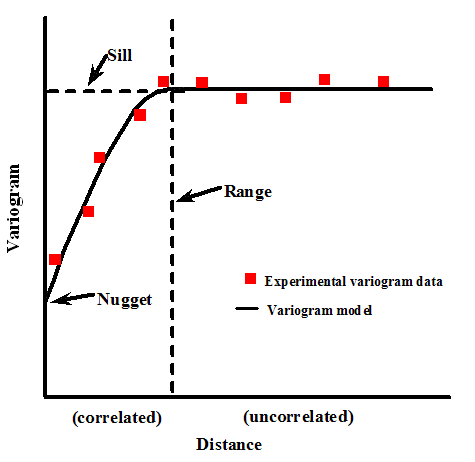
Source: https://vsp.pnnl.gov/help/Vsample/Kriging_Variogram_Model.htm#:~:text=The%20nugget%20is%20the%20y,which%20the%20variogram%20levels%20off.


## Variogram for Nigardsbreen

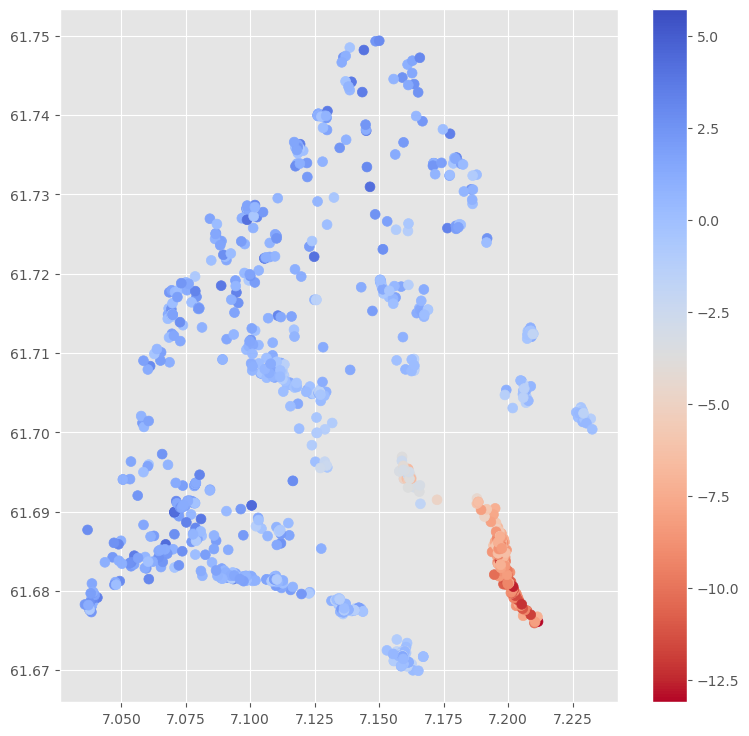

In [29]:
# Plot Nigardsbreen stake data

data_nig = data[data['BREID']==2297]

plt.style.use('ggplot')
x = data_nig['lon'].values
y = data_nig['lat'].values
mb = data_nig['balance_netto'].values

fig, ax = plt.subplots(1, 1, figsize=(9, 9))
art = ax.scatter(x, y, s=50, c=mb.flatten(), cmap='coolwarm_r')
plt.colorbar(art)

In [35]:
# Get stakes with coordinates

coords = np.stack((x,y), axis=1)

coords=coords[~np.isnan(mb)]
mb_clean=mb[~np.isnan(mb)]

In [36]:
# Variogram models

models = {
    "Gaussian": gs.Gaussian,
    "Exponential": gs.Exponential,
    "Matern": gs.Matern,
    "Stable": gs.Stable,
    "Rational": gs.Rational,
    "Circular": gs.Circular,
    "Spherical": gs.Spherical,
    "SuperSpherical": gs.SuperSpherical,
    "JBessel": gs.JBessel,
}
scores = {}

In [37]:
# Estimate the variogram of the field
bin_center, gamma = gs.vario_estimate((x, y), mb, latlon=True, geo_scale=gs.KM_SCALE)

In [38]:
print('bin_center: ', bin_center)
print('gamma: ', gamma)
print("estimated bin number:", len(bin_center))
print("maximal bin distance:", max(bin_center))

bin_center:  [0.17817956 0.53453869 0.89089781 1.24725694 1.60361607 1.95997519
 2.31633432 2.67269344 3.02905257 3.3854117  3.74177082 4.09812995
 4.45448907 4.8108482  5.16720733 5.52356645 5.87992558 6.2362847
 6.59264383 6.94900296 7.30536208 7.66172121]
gamma:  [ 1.42615196  1.66639674  1.82598933  1.66908237  2.03087045  2.21696334
  3.89026082  4.69253133  3.95858249  4.30337086  6.22252935  6.0167934
  8.28936306  8.18007451  7.01797375  7.6476796   9.22417964 10.3252115
 10.38434667  9.48386555  8.6368231   8.96252837]
estimated bin number: 22
maximal bin distance: 7.6617212082317


C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\gstools\covmodel\plot.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


JBessel(dim=2, var=5.81, len_scale=1.82, nugget=1.24, nu=6.38e-13)


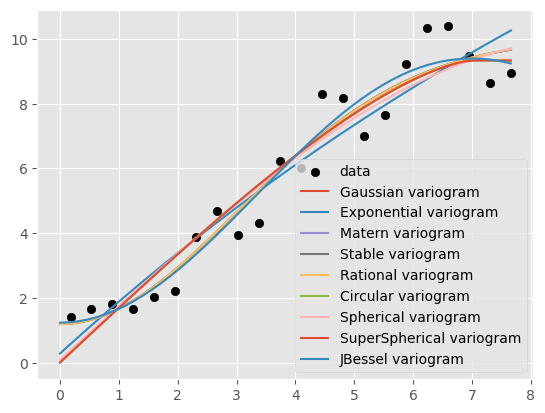

In [39]:
# plot the estimated variogram
plt.scatter(bin_center, gamma, color="k", label="data")
ax = plt.gca()

# fit all models to the estimated variogram
for model in models:
    fit_model = models[model](dim=2)
    para, pcov, r2 = fit_model.fit_variogram(bin_center, gamma, return_r2=True)
    fit_model.plot(x_max=max(bin_center), ax=ax)
    scores[model] = r2
print(fit_model)

In [40]:
ranking = sorted(scores.items(), key=lambda item: item[1], reverse=True)
print("RANKING by Pseudo-r2 score")
for i, (model, score) in enumerate(ranking, 1):
    print(f"{i:>6}. {model:>15}: {score:.5}")

plt.show()

RANKING by Pseudo-r2 score
     1.         JBessel: 0.95154
     2.        Gaussian: 0.94479
     3.          Stable: 0.94479
     4.          Matern: 0.94479
     5.        Rational: 0.94455
     6.        Circular: 0.93148
     7.  SuperSpherical: 0.93148
     8.       Spherical: 0.92505
     9.     Exponential: 0.91646


## Variogram using four glaciers of JOB (Nigardsbreen, Austdalsbreen, Vesledalsbreen, Tunsbergdalsbreen)


In [41]:
# Variogram using four glaciers of JOB (Nigardsbreen, Austdalsbreen, Vesledalsbreen, Tunsbergdalsbreen)
data_job = data[data['BREID'].isin([2297, 2474, 2320, 2478])]

x = data_job['lon'].values
y = data_job['lat'].values
mb = data_job['balance_netto'].values
coords = np.stack((x,y), axis=1)

# Use only data that is not nan
coords=coords[~np.isnan(mb)]
mb_clean=mb[~np.isnan(mb)]

In [42]:
# estimate the variogram of the field
bin_center, gamma = gs.vario_estimate((x, y), mb, latlon=True, geo_scale=gs.KM_SCALE)

print('bin_center: ', bin_center)
print('gamma: ', gamma)
print("estimated bin number:", len(bin_center))
print("maximal bin distance:", max(bin_center))

bin_center:  [ 0.43626309  1.30878928  2.18131547  3.05384166  3.92636785  4.79889404
  5.67142023  6.54394642  7.41647261  8.2889988   9.16152499 10.03405118
 10.90657737 11.77910356 12.65162975 13.52415594 14.39668213 15.26920832
 16.14173451 17.0142607  17.88678689 18.75931308]
gamma:  [ 1.56873909  1.79633856  3.43979264  4.15645707  6.00045087  8.0218296
  8.00103674  9.96294347  8.58742692  8.09319922 11.00821536 17.21906935
 16.78995484 18.21290846 18.37764408 18.62654846 20.08760497 16.83741924
 13.19486775 12.58421538 20.80223705 18.48515438]
estimated bin number: 22
maximal bin distance: 18.759313075525423


JBessel(dim=2, var=15.7, len_scale=2.44, nugget=1.99, nu=1.92)


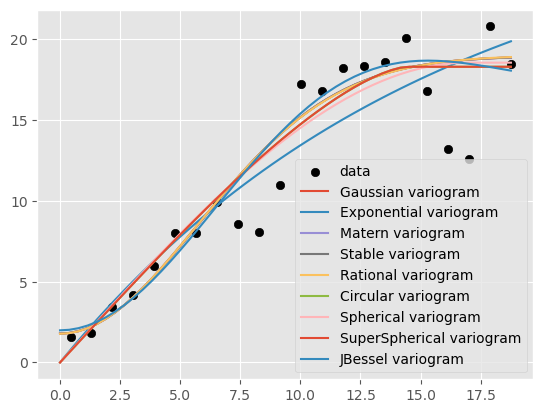

In [43]:
# plot the estimated variogram
plt.scatter(bin_center, gamma, color="k", label="data")
ax = plt.gca()

# fit all models to the estimated variogram
for model in models:
    fit_model = models[model](dim=2)
    para, pcov, r2 = fit_model.fit_variogram(bin_center, gamma, return_r2=True)
    fit_model.plot(x_max=max(bin_center), ax=ax)
    scores[model] = r2
print(fit_model)

In [44]:
ranking = sorted(scores.items(), key=lambda item: item[1], reverse=True)
print("RANKING by Pseudo-r2 score")
for i, (model, score) in enumerate(ranking, 1):
    print(f"{i:>6}. {model:>15}: {score:.5}")

plt.show()

RANKING by Pseudo-r2 score
     1.        Circular: 0.85569
     2.  SuperSpherical: 0.85569
     3.         JBessel: 0.85051
     4.       Spherical: 0.845
     5.          Matern: 0.84448
     6.          Stable: 0.84448
     7.        Gaussian: 0.84448
     8.        Rational: 0.84414
     9.     Exponential: 0.82694


Spherical and exponential are most widely used.

SuperSpherical(dim=2, var=18.3, len_scale=14.4, nugget=2.06e-11, nu=0.5)


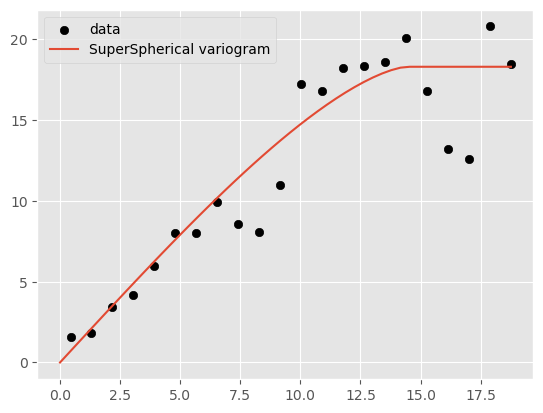

In [45]:
# SuperSpherical, Circular variogram
plt.scatter(bin_center, gamma, color="k", label="data")
ax = plt.gca()

# fit all models to the estimated variogram
fit_model = gs.SuperSpherical(dim=2)
para, pcov, r2 = fit_model.fit_variogram(bin_center, gamma, return_r2=True)
fit_model.plot(x_max=max(bin_center), ax=ax)

print(fit_model)

Nugget (y-intercept): The nugget is the y-intercept of the variogram. In practical terms, the nugget represents the small-scale variability of the data. A portion of that short range variability can be the result of measurement error. 
(https://vsp.pnnl.gov/help/Vsample/Kriging_Variogram_Model.htm#:~:text=The%20nugget%20is%20the%20y,which%20the%20variogram%20levels%20off.)

Spherical(dim=2, var=18.6, len_scale=16.9, nugget=3.63e-17)


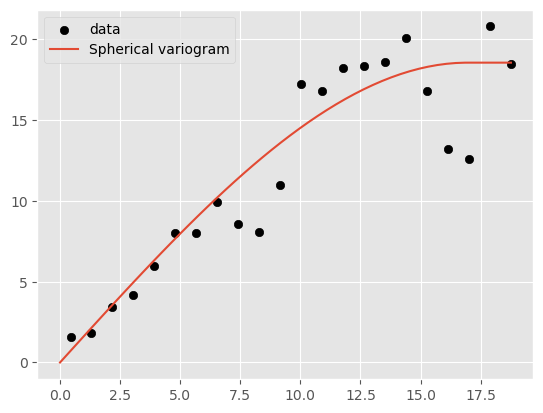

In [46]:
# Circular variogram
plt.scatter(bin_center, gamma, color="k", label="data")
ax = plt.gca()

# fit all models to the estimated variogram
fit_model = gs.Spherical(dim=2)
para, pcov, r2 = fit_model.fit_variogram(bin_center, gamma, return_r2=True)
fit_model.plot(x_max=max(bin_center), ax=ax)

print(fit_model)

## Correlation plots

In [47]:
# Additional libraries
from numpy.random import randn
from seaborn import heatmap
from itertools import combinations

<Axes: >

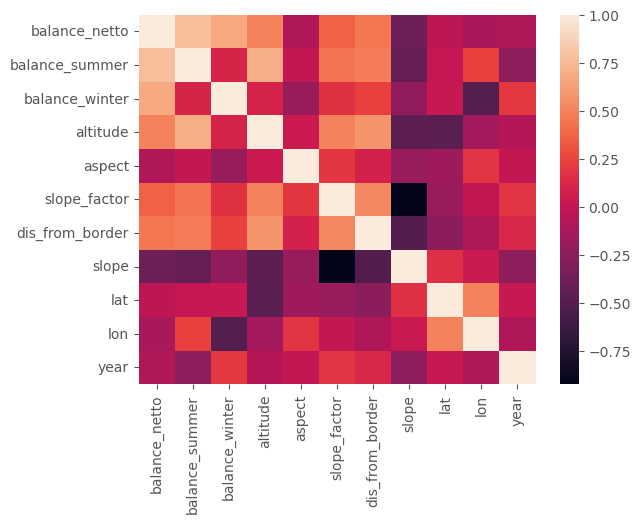

In [48]:
#Plot correlations topo
columns=['balance_netto','balance_summer','balance_winter','altitude','aspect',
         'slope_factor', 'dis_from_border','slope','lat','lon','year']

#pearson : standard correlation coefficient
#kendall : Kendall Tau correlation coefficient
#spearman : Spearman rank correlation

corr = data[columns].corr(method='spearman')
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Negative correlation between annual/summer balance and slope (higher slope = more positive mb?).
Negative correlation between altitude and slope (higher altitude = lower slope)

Lower elevations have steeper slopes - Nigardsbreen?

Slope correlates with slope factor, remove slope factor from features.

In [49]:
# Select columns to drop
cols = ['BREID','RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north',
        'balance_winter','balance_summer','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
        'topo','dis_from_border','year','region','geo_region']

topo = ['altitude', 'slope', 'aspect', 'altitude_climate','slope_factor','lat','lon']
snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
snow_cover = ['snowc_oct','snowc_nov','snowc_dec','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
snow_depth_we = ['sd_oct','sd_nov','sd_dec','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
snow_temp = ['tsn_oct','tsn_nov','tsn_dec','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
snow_melt = ['smlt_oct','smlt_nov','smlt_dec','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
dewpt_temp = ['d2m_oct','d2m_nov','d2m_dec','d2m_jan','d2m_feb','d2m_mar','d2m_apr','d2m_may','d2m_jun','d2m_jul','d2m_aug','d2m_sep']
surf_press = ['sp_oct','sp_nov','sp_dec','sp_jan','sp_feb','sp_mar','sp_apr','sp_may','sp_jun','sp_jul','sp_aug','sp_sep']
snowfall = ['sf_oct','sf_nov','sf_dec','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
snow_albedo = ['asn_oct','asn_nov','asn_dec','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']

drop_cols = [y for x in [cols, topo, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, dewpt_temp, surf_press, snowfall, snow_albedo] for y in x]

#Select features
data_selected = data.drop(drop_cols, axis=1)
corr = data_selected.corr(method='spearman')

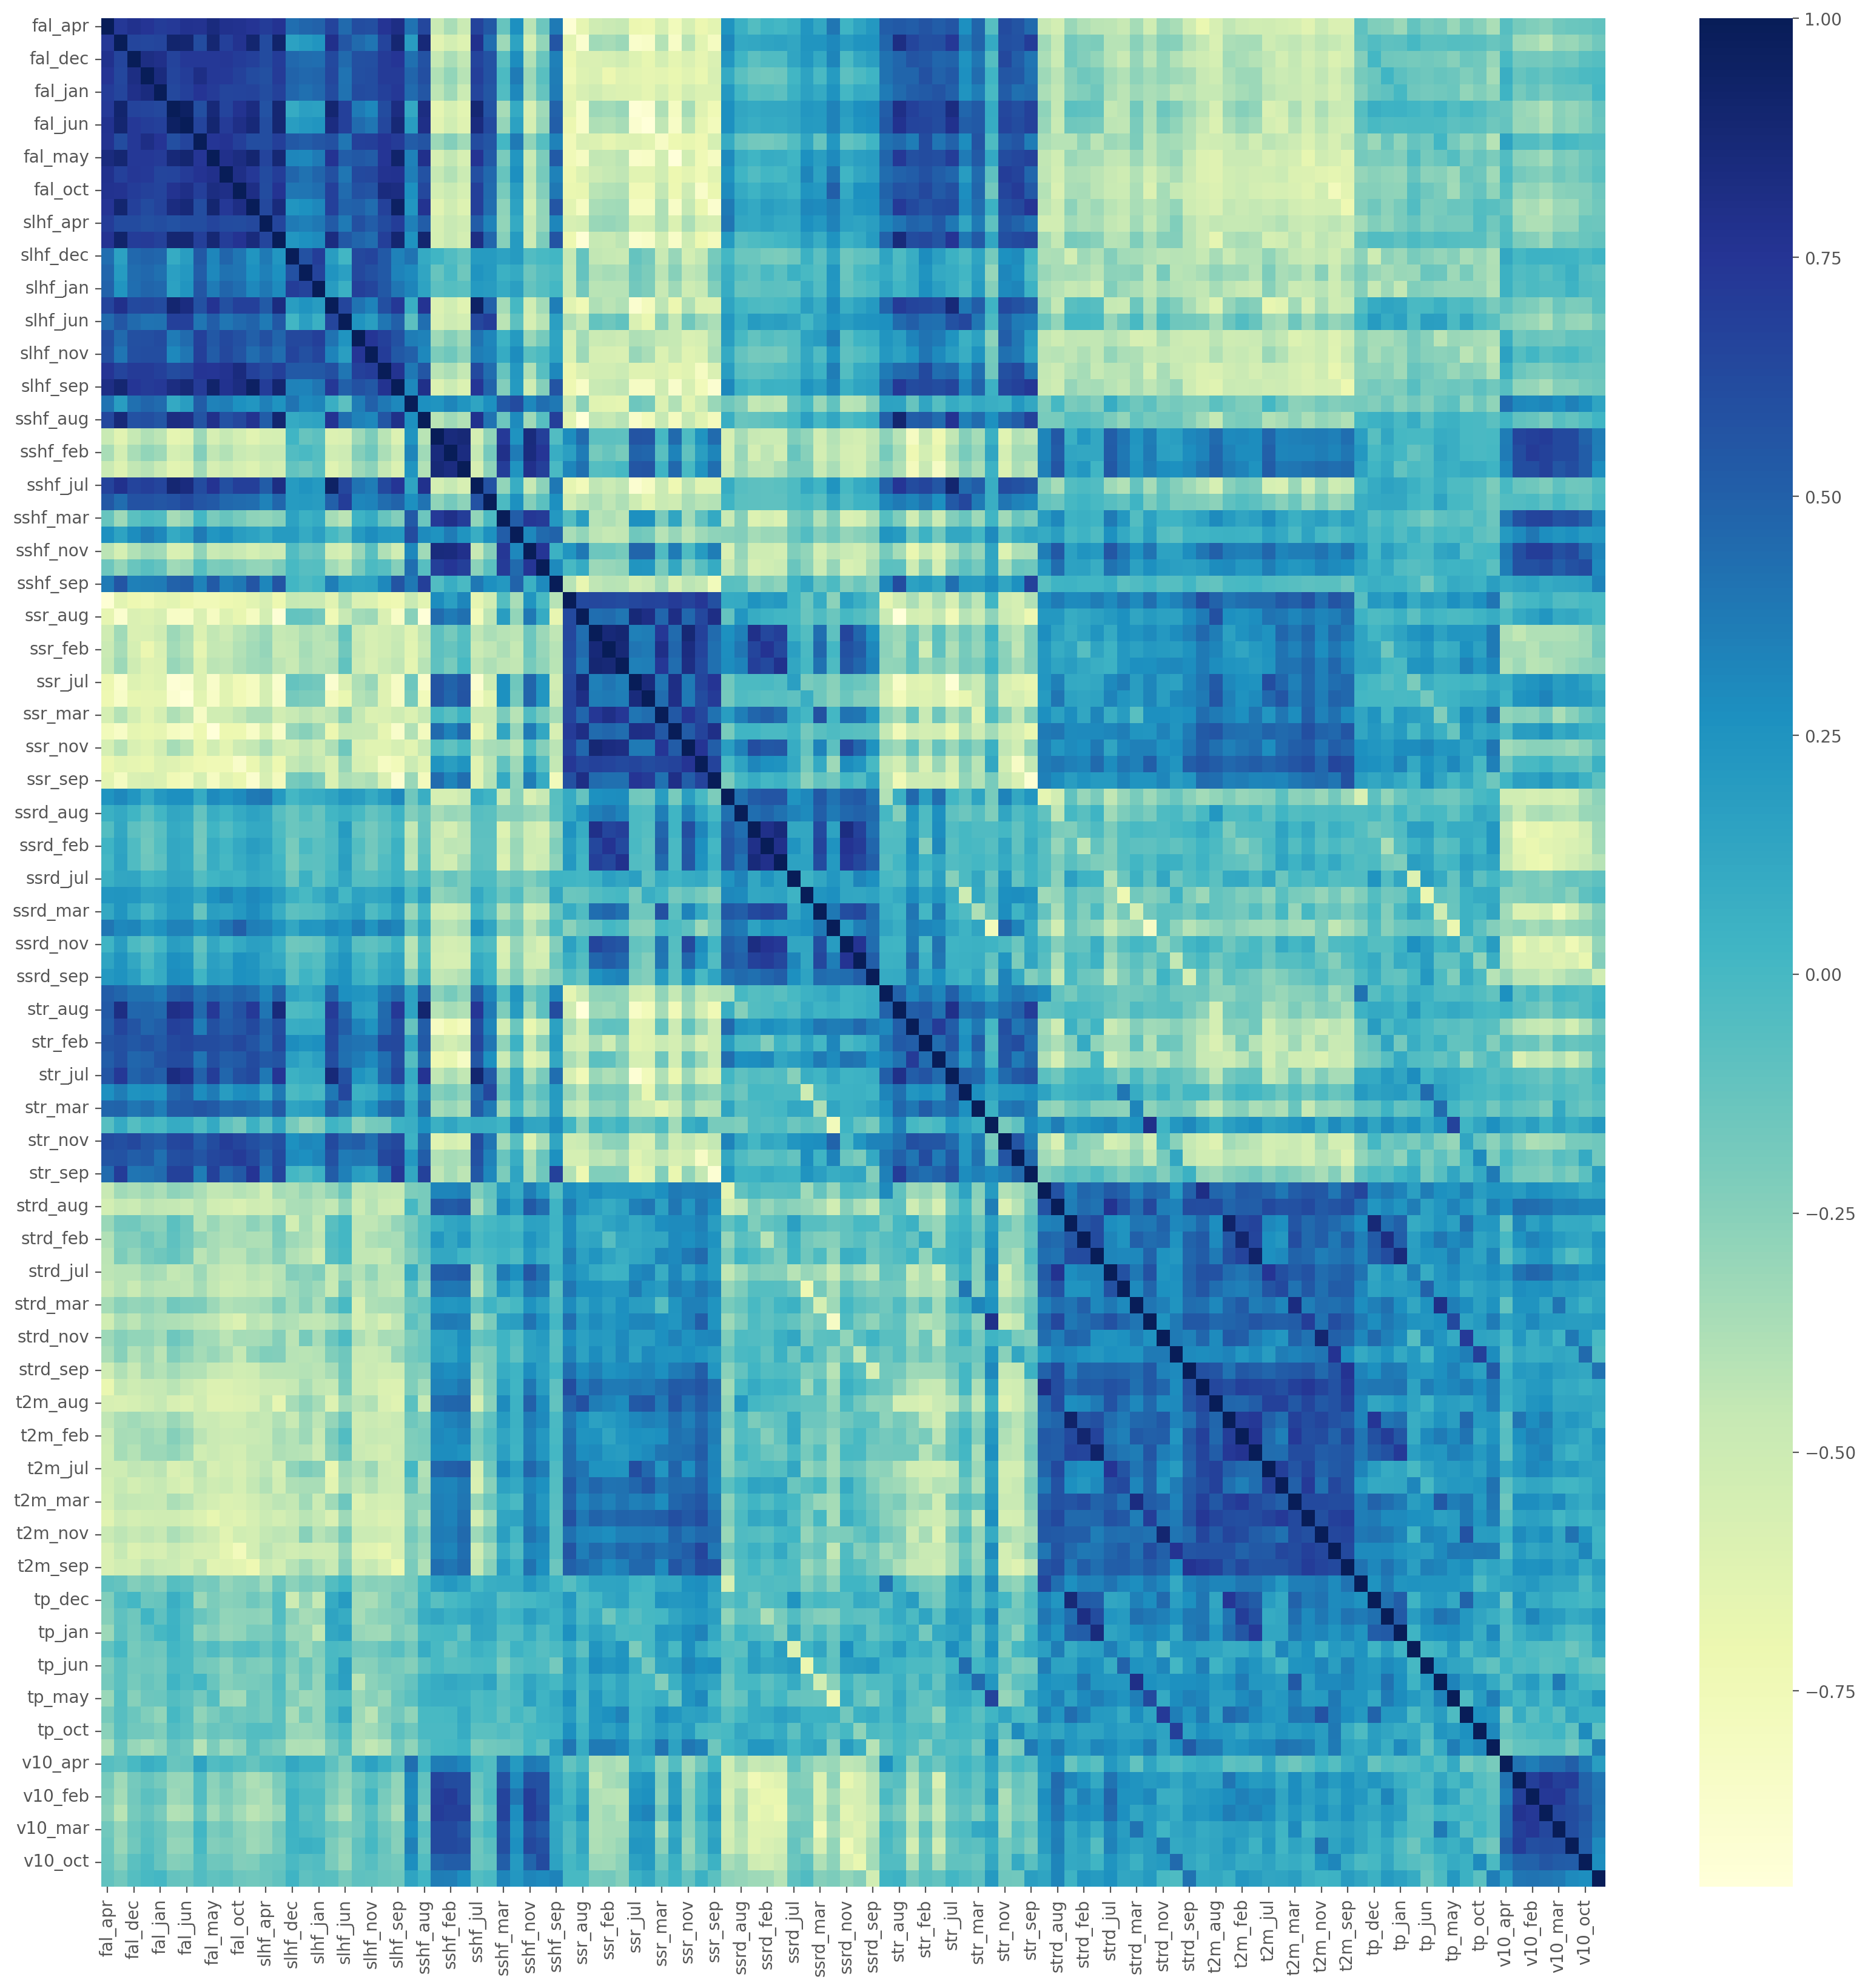

In [50]:
def absHighPass(df, absThresh):
    passed = set()
    for (r,c) in combinations(df.columns, 2):
        if (abs(df.loc[r,c]) >= absThresh):
            passed.add(r)
            passed.add(c)
    passed = sorted(passed)
    return df.loc[passed,passed]

fig, ax = plt.subplots(1,1,figsize=(20,20), dpi=200)
heatmap(absHighPass(corr,0.5),cmap="YlGnBu", ax=ax)
plt.show()